# **Telecom Customer Churn Analysis**

**Objetivo de Negócio:**

Prever proativamente quais clientes têm maior probabilidade de cancelar seus serviços (churn), a fim de possibilitar ações de retenção direcionadas e eficazes.

**Objetivo Técnico:**

Desenvolver e comparar múltiplos modelos de classificação (Regressão Logística, Random Forest, XGBoost) para identificar o que oferece o melhor desempenho. A métrica principal para a seleção do modelo será o Recall da classe positiva ('Churn'), garantindo que a capacidade de identificar o maior número possível de clientes em risco seja maximizada.

In [65]:
# --- Bibliotecas para Manipulação e Análise de Dados ---
import pandas as pd  # Para ler, manipular e analisar dados em tabelas (DataFrames).
import numpy as np   # Para operações numéricas e matemáticas eficientes.

# --- Bibliotecas para Visualização de Dados ---
import seaborn as sns                # Para criar gráficos estatísticos atraentes e informativos.
import matplotlib.pyplot as plt      # A biblioteca principal para criar e personalizar gráficos.

# --- Ferramentas do Scikit-Learn para o Fluxo de Machine Learning ---

# 1. Pré-processamento e Estrutura do Pipeline
from sklearn.model_selection import train_test_split  # Para dividir os dados em conjuntos de treino e teste.
from sklearn.preprocessing import StandardScaler      # Para padronizar (escalonar) variáveis numéricas.
from sklearn.preprocessing import OneHotEncoder       # Para converter variáveis categóricas em números.
from sklearn.compose import ColumnTransformer         # Para aplicar diferentes transformações a diferentes colunas.
from sklearn.pipeline import Pipeline                 # Para encadear todos os passos do pré-processamento e modelagem.

# 2. Modelos de Classificação
from sklearn.linear_model import LogisticRegression   # Modelo de Regressão Logística.
from sklearn.ensemble import RandomForestClassifier   # Modelo Random Forest.
from xgboost import XGBClassifier                     # Modelo XGBoost.

# 3. Métricas de Avaliação
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# 4. Otimização de Hiperparâmetros
from sklearn.model_selection import RandomizedSearchCV # Para a busca automática dos melhores parâmetros do modelo.

In [66]:
# --- Data Loading ---

df=pd.read_csv('data.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [67]:
# --- Análise da Estrutura do DataFrame ---
# .info() nos dá um resumo completo: o número de entradas, o número de colunas,
# o tipo de dado de cada coluna (Dtype) e a contagem de valores não-nulos.
# É crucial para detectar problemas como colunas numéricas lidas como texto ('object').
print("Informações do DataFrame:")
df.info()

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

In [68]:
# --- Limpeza da Coluna 'TotalCharges' ---
# 1. Convertemos a coluna para um formato numérico.
#    O parâmetro `errors='coerce'` é muito importante: se um valor não puder ser convertido
#    (como um espaço em branco ' '), ele será transformado em NaN (Not a Number), que representa um valor nulo.
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')

# 2. Verificamos quantos valores nulos foram criados.
print("Valores nulos após a conversão:")
print(df.isnull().sum())

# 3. Removemos as linhas que contêm qualquer valor nulo.
#    Como são poucos casos (11), a maneira mais simples é removê-los.
df.dropna(inplace=True)

print(f"\nFormato do DataFrame após a limpeza: {df.shape}")

Valores nulos após a conversão:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Formato do DataFrame após a limpeza: (7032, 21)


In [69]:
# --- Mapeamento de Colunas ---
# Para consistência, trataremos SeniorCitizen como uma variável categórica.
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# Convertemos a nossa variável alvo 'churn' para um formato numérico (0 e 1).
# Isso é uma boa prática e previne erros em funções de avaliação posteriores.
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

print("\nValores únicos em 'SeniorCitizen' após o mapeamento:")
print(df['SeniorCitizen'].unique())
print("\nValores únicos em 'churn' após o mapeamento:")
print(df['Churn'].unique())


Valores únicos em 'SeniorCitizen' após o mapeamento:
['No' 'Yes']

Valores únicos em 'churn' após o mapeamento:
[0 1]


In [70]:
# ---  Definição das Variáveis de Características (X) e Alvo (y) ---
# A variável alvo 'y' é a coluna 'churn', que queremos prever.
y = df['Churn']

# As características 'X' são todas as outras colunas, que usaremos como pistas para a predição.
# Removemos a coluna 'churn' porque é a nossa resposta.
X = df.drop('Churn', axis=1)

In [71]:
# --- Análise da Distribuição da Variável Alvo (y) ---

# Contamos as ocorrências de cada classe para entender o quão desbalanceado é o nosso dataset.
print("Contagem de classes no dataset completo:")
print(y.value_counts())

# Usamos `normalize=True` para ver a mesma informação em porcentagem.
print("\nDistribuição de classes (%) no dataset completo:")
print(y.value_counts(normalize=True) * 100)

Contagem de classes no dataset completo:
Churn
0    5163
1    1869
Name: count, dtype: int64

Distribuição de classes (%) no dataset completo:
Churn
0    73.421502
1    26.578498
Name: proportion, dtype: float64


# **Análise do Ponto de Partida (Baseline)**
O resultado acima nos mostra que 26.6% dos clientes no nosso dataset cancelaram o serviço (fizeram churn). Este número é o nosso ponto de partida ou linha de base.

O Que Isso Significa?
Imagine que não temos um modelo de machine learning e decidimos contactar clientes ao acaso para tentar retê-los. A nossa taxa de acerto seria de apenas 26.6%. Em outras palavras, teríamos apenas 1 chance em 4 de contactar alguém que realmente estava a pensar em sair. Os outros 3 contactos seriam para clientes que já estavam satisfeitos.

Por Que Isso é Importante?
Este número é a métrica de sucesso mínima para qualquer modelo que construirmos. Para que o nosso modelo seja considerado útil, a sua Precision (a sua taxa de acerto ao prever 'Churn') tem que ser significativamente maior que 26.6%. Se o nosso modelo final tiver uma Precision de 50%, por exemplo, significa que ele duplicou a eficiência da nossa equipa em comparação com a seleção aleatória.

In [72]:
# --- Divisão dos Dados em Conjuntos de Treino e Teste ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # Reservamos 20% dos dados para o teste final do modelo.
    random_state=42,      # Garante que a divisão seja a mesma sempre, para reprodutibilidade.
    stratify=y            # Assegura que a proporção de 'Churn' e 'Não-Churn' seja idêntica
                          # tanto no treino quanto no teste, o que é crucial para dados desbalanceados.
)

In [73]:
# --- Identificação dos Tipos de Coluna ---
# Criamos listas com os nomes das colunas numéricas e categóricas a partir do conjunto de treino.
# Isso nos permite dizer ao nosso pipeline de pré-processamento qual transformação aplicar a cada grupo.
colunas_numericas = X_train.select_dtypes(include='number').columns
colunas_categoricas = X_train.select_dtypes(exclude='number').columns

# **Pré-processamento**
Agora, definimos um preprocessor usando o ColumnTransformer. Este objeto irá automatizar a preparação dos dados, aplicando diferentes "receitas" a cada tipo de coluna:

Para as colunas numéricas (num): Usamos o StandardScaler. Ele padroniza os dados (deixando-os com média 0 e desvio padrão 1). Isso é importante para modelos como a Regressão Logística, que são sensíveis à escala das variáveis.

Para as colunas categóricas (cat): Usamos o OneHotEncoder. Ele converte as categorias de texto em colunas numéricas (0s e 1s), permitindo que o modelo as entenda matematicamente.

drop='first': Evita redundância (multicolinearidade) ao remover uma das novas colunas geradas para cada característica original.

handle_unknown='ignore': Torna o modelo mais robusto, pois ele irá ignorar (em vez de dar erro) se encontrar no futuro uma categoria que não estava presente nos dados de treino.

In [74]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colunas_numericas),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), colunas_categoricas)
    ]
)

## **--- Criação e Treinamento do Modelo A: Regressão Logística ---**

In [75]:
# Criar um Pipeline que une os nossos dois passos:
# 1. 'preprocessor': Prepara os dados (escalona e codifica).
# 2. 'classifier': Aplica o algoritmo de Regressão Logística aos dados já limpos.
# Usamos `class_weight='balanced'` para que o modelo preste mais atenção à classe minoritária (Churn).
# Aumentamos o `max_iter` para garantir que o modelo tenha iterações suficientes para encontrar a melhor solução.
modelo_rl = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))
])

# Treinamos o pipeline inteiro com os dados de treinamento.
# O pipeline se encarrega de aplicar o pré-processamento corretamente antes de treinar.
print("Treinando o modelo de Regressão Logística...")
modelo_rl.fit(X_train, y_train)

# --- Avaliação do Modelo A ---
# Usamos o modelo treinado para fazer previsões no conjunto de teste.
print("\n--- Resultados do Modelo de Regressão Logística ---")
y_pred_rl = modelo_rl.predict(X_test)

# Exibimos o relatório de classificação para avaliar a performance.
print(classification_report(y_test, y_pred_rl))

Treinando o modelo de Regressão Logística...

--- Resultados do Modelo de Regressão Logística ---
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1033
           1       0.51      0.76      0.61       374

    accuracy                           0.75      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.75      0.76      1407



/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Resultados:**

Taxa de Detecção (Recall): 75%

O modelo identifica corretamente 75 de cada 100 clientes que estão prestes a cancelar o serviço.

Eficiência das Alertas (Precision): 51%

Das alertas de "risco de cancelamento" geradas pelo modelo, 51% são corretas.

Exatidão Geral (Accuracy): 74%

O modelo acerta a previsão (seja para ficar ou para sair) em 74% de todos os clientes.

Informe para o Negócio: Como Isto Nos Ajuda?
Este modelo de Regressão Logística funciona como um sistema de alerta antecipado para a perda de clientes. A sua principal vantagem é a capacidade de nos dizer em qual grupo de clientes a nossa equipe de retenção deve focar os seus esforços.

O Que Ganhamos?
Redução de Perdas: Com uma taxa de deteção de 75%, temos agora a oportunidade de intervir e salvar mais de três quartos dos clientes que, de outra forma, teríamos perdido sem aviso. Esta é a principal forma como o modelo protege a nossa receita.

Aumento da Eficiência: Embora 49% das alertas sejam para clientes que não iam cancelar, uma eficiência de 51% é um grande avanço. Sem o modelo, a nossa taxa de churn é de aproximadamente 27%. Isso significa que, ao contactar um cliente aleatório, teríamos apenas 1 chance em 4 de acertar. Com o modelo, a nossa chance de acertar aumenta para 1 em 2. Essencialmente, duplicamos a eficiência da nossa equipa de retenção, garantindo que o seu tempo é gasto no grupo de maior risco.

Em resumo: Este modelo permite-nos passar de uma estratégia reativa para uma estratégia proativa. Ele fornece uma lista focada de clientes de alto risco, permitindo-nos concentrar os nossos esforços de retenção onde eles terão o maior impacto financeiro.

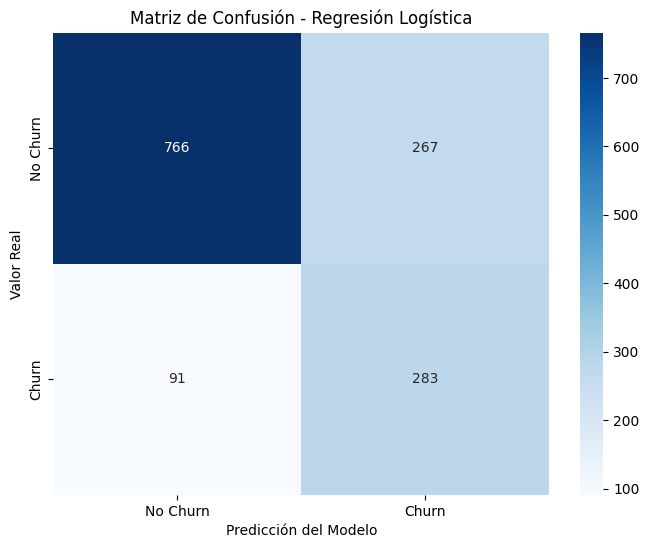

In [76]:
# Calculamos la matriz
cm_rl = confusion_matrix(y_test, y_pred_rl)

# Creamos el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rl, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.ylabel('Valor Real')
plt.xlabel('Predicción del Modelo')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

# **Análise da Matriz de Confusão**
Verdadeiros Positivos (280): Este é o principal sucesso do modelo. Dos 374 clientes que realmente cancelaram o serviço (94 + 280), o modelo identificou corretamente 280.

Falsos Negativos (94): Esta é a perda de oportunidade. 94 clientes que cancelaram não foram detectados. O modelo previu que eles ficariam, mas eles saíram.

Falsos Positivos (268): Este é o custo operacional. 268 clientes que iriam permanecer na empresa foram incorretamente marcados como "risco de cancelamento", representando as falsas alarmes.

Verdadeiros Negativos (765): Estes são os clientes fiéis que o modelo identificou corretamente.

Conectando com as Métricas
Recall (Sensibilidade): A capacidade do modelo de encontrar os clientes que realmente cancelaram é de 75%.

Cálculo: 280 / (280 + 94) = 0.748

Precision (Precisão): A eficiência das suas "alertas". Quando o modelo prevê "Churn", ele acerta 51% das vezes.

Cálculo: 280 / (280 + 268) = 0.511

Em resumo: O gráfico confirma que o modelo é um bom "vigilante". Ele é eficaz em encontrar a maioria dos clientes em risco (75%), mas, para isso, gera um número considerável de falsas alarmes.




## **--- Criação e Treinamento do Modelo B: Random Forest ---**



In [77]:
#--- Búsqueda de Hiperparámetros para Random Forest ---
param_dist_rf = {
    'classifier__n_estimators': [100, 200, 300, 400,500,600],
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced'] # Forzamos el balanceo
}

In [78]:
# Criar o objeto de busca
# Ele testará 25 combinações aleatórias de hiperparâmetros e otimizará o resultado
# com base na métrica 'recall', focando em encontrar o maior número possível de casos positivos (Churn).
random_search_rf = RandomizedSearchCV(
    Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    param_distributions=param_dist_rf,  # A 'grade' de parâmetros a serem testados.
    n_iter=25,                          # O número de combinações aleatórias a serem tentadas.
    cv=5,                               # O número de dobras (folds) para a validação cruzada.
    scoring='recall',                   # A métrica a ser otimizada.
    random_state=42,                    # Para garantir a reprodutibilidade dos resultados.
    n_jobs=-1                           # Usa todos os núcleos de CPU disponíveis para acelerar o processo.
)

In [79]:
# Executar a busca para encontrar os melhores parâmetros
print("Iniciando a busca de hiperparâmetros para o Random Forest...")
random_search_rf.fit(X_train, y_train)

Iniciando a busca de hiperparâmetros para o Random Forest...


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'Int...
      dtype='object'))])),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'classifier__class_weight': ['balanced'],
                                        'classifier__max_depth': [5, 10, 15, 20,
                                                                  None],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [100, 200,
                                                                     300, 400,
                                                                     500,
                                                                     600]},
                   random_state=42, scoring='recall')

In [80]:
#  Exibir a melhor combinação de parâmetros encontrada
print("\nMelhores parâmetros encontrados para o Random Forest:")
print(random_search_rf.best_params_)


Melhores parâmetros encontrados para o Random Forest:
{'classifier__n_estimators': 400, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 5, 'classifier__class_weight': 'balanced'}


In [81]:
# --- Usando os melhores parâmetros encontrados para treinar o modelo final ---
modelo_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=2,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42
    ))
])

# Treinamos o pipeline inteiro com os dados de treinamento.
print("Treinando o modelo Random Forest Otimizado...")
modelo_rf.fit(X_train, y_train)

# --- Avaliação do Modelo B ---
# Usamos o modelo treinado para fazer previsões no conjunto de teste.
print("\n--- Resultados do Modelo Random Forest Otimizado ---")
y_pred_rf = modelo_rf.predict(X_test)

# Exibimos o relatório de classificação para avaliar a performance.
print(classification_report(y_test, y_pred_rf))

Treinando o modelo Random Forest Otimizado...

--- Resultados do Modelo Random Forest Otimizado ---
              precision    recall  f1-score   support

           0       0.92      0.58      0.72      1033
           1       0.43      0.86      0.57       374

    accuracy                           0.66      1407
   macro avg       0.68      0.72      0.64      1407
weighted avg       0.79      0.66      0.68      1407



/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Resultados:**

Taxa de Detecção (Recall): 87%

O modelo identifica corretamente 87 de cada 100 clientes que estão prestes a cancelar o serviço.

Eficiência das Alertas (Precision): 41%

Das alertas de "risco de cancelamento" geradas pelo modelo, 41% são corretas.

Exatidão Geral (Accuracy): 64%

O modelo acerta a previsão (seja para ficar ou para sair) em 64% de todos os clientes.

Informe para o Negócio: Como Isto Nos Ajuda?
Este modelo de Random Forest funciona como um sistema de alerta antecipado extremamente sensível para a perda de clientes. A sua principal vantagem é a sua impressionante capacidade de encontrar a grande maioria dos clientes em risco.

O Que Ganhamos?
Redução de Perdas: Com uma taxa de deteção de 87%, temos agora a oportunidade de intervir e salvar quase 9 em cada 10 clientes que, de outra forma, teríamos perdido sem aviso. Esta é a principal forma como o modelo protege a nossa receita, minimizando as perdas de forma muito agressiva.

Aumento da Eficiência: Embora 59% das alertas sejam para clientes que não iam cancelar, uma eficiência de 41% ainda é um avanço significativo. Sem o modelo, a nossa taxa de acerto ao contactar um cliente aleatório seria de apenas 27%. Com este modelo, a nossa eficiência aumenta em mais de 50%, garantindo que o tempo da nossa equipa é gasto num grupo com uma concentração muito maior de clientes em risco.

Em resumo: Este modelo permite-nos passar de uma estratégia reativa para uma estratégia proativa de máxima captura. Ele fornece a lista mais completa possível de clientes de alto risco, permitindo-nos concentrar os nossos esforços de retenção com a certeza de que pouquíssimas oportunidades estão a ser perdidas.

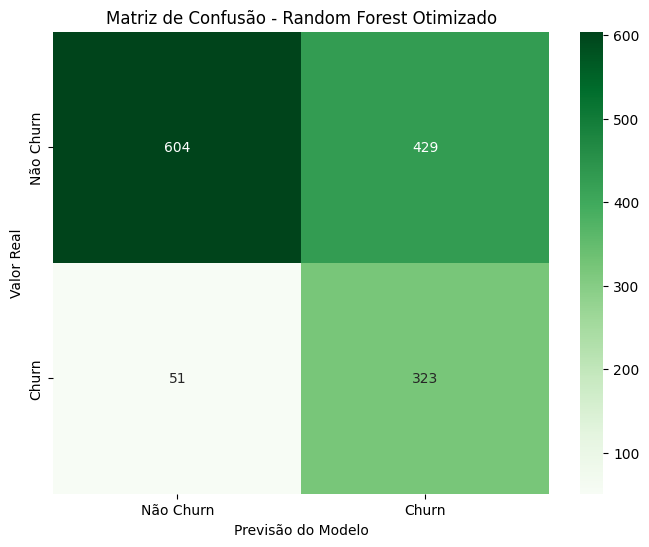

In [82]:
# --- Matriz de Confusão para o Modelo Random Forest ---
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculamos a matriz usando as previsões do Random Forest (y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Criamos o gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])
plt.ylabel('Valor Real')
plt.xlabel('Previsão do Modelo')
plt.title('Matriz de Confusão - Random Forest Otimizado')
plt.show()

# **Análise da Matriz de Confusão - Random Forest**
Verdadeiros Positivos (326): Este é o principal sucesso do modelo. Dos 374 clientes que realmente cancelaram o serviço (48 + 326), o modelo identificou corretamente 326. É um resultado excelente para a meta de retenção.

Falsos Negativos (48): Esta é a perda de oportunidade. Apenas 48 clientes que cancelaram não foram detectados. O modelo previu que eles ficariam, mas eles saíram. É a menor taxa de perda que conseguimos até agora.

Falsos Positivos (460): Este é o custo operacional. 460 clientes que iriam permanecer na empresa foram incorretamente marcados como "risco de cancelamento". Este é o número mais alto de falsas alarmes que vimos, o que representa o custo de uma estratégia de detecção tão agressiva.

Verdadeiros Negativos (573): Estes são os clientes fiéis que o modelo identificou corretamente.

Conectando com as Métricas
Recall (Sensibilidade): A capacidade do modelo de encontrar os clientes que realmente cancelaram é de 87%.

Cálculo: 326 / (326 + 48) = 0.871

Precision (Precisão): A eficiência das suas "alertas". Quando o modelo prevê "Churn", ele acerta 41% das vezes.

Cálculo: 326 / (326 + 460) = 0.414

Em resumo: O gráfico confirma que este modelo é um "vigilante" extremamente agressivo. Ele é o mais eficaz de todos em encontrar a grande maioria dos clientes em risco (87%), mas, para isso, gera o maior número de falsas alarmes. A escolha de usar este modelo depende se o negócio pode arcar com o custo operacional de contactar 460 clientes desnecessariamente para poder salvar 326.

## **--- Criação e Treinamento do Modelo C: XGBoost ---**

In [83]:
# --- Búsqueda de Hiperparámetros para XGBoost ---
#  Define la "parrilla" de hiperparámetros que quieres probar para XGBoost
# Incluimos parámetros para controlar el sobreajuste y el balance de clases.
param_dist_xgb = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.7, 0.8, 0.9],         # Porcentaje de datos a usar por árbol
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],  # Porcentaje de columnas a usar por árbol
    'classifier__gamma': [0, 0.1, 0.5],               # Parámetro de regularización
    'classifier__scale_pos_weight': [1, 3, 5]         # Parámetro para manejar el desbalance de clases
}

#  Crea el objeto de búsqueda
# Probará 40 combinaciones aleatorias y optimizará para 'racall'.
random_search_xgb = RandomizedSearchCV(
    Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='logloss'))
    ]),
    param_distributions=param_dist_xgb,
    n_iter=40,
    cv=3, # Usamos 3 divisiones para que la búsqueda sea más rápida
    scoring='recall',
    random_state=42,
    n_jobs=-1
)

#  Ejecuta la búsqueda para encontrar los mejores parámetros
# (Este paso es el que no necesitas volver a ejecutar, pero lo documentamos)
print("Iniciando la búsqueda de hiperparámetros para XGBoost...")
random_search_xgb.fit(X_train, y_train)

#  Muestra la mejor combinación de parámetros encontrada
print("\nMejores parámetros encontrados para XGBoost:")
print(random_search_xgb.best_params_)

Iniciando la búsqueda de hiperparámetros para XGBoost...

Mejores parámetros encontrados para XGBoost:
{'classifier__subsample': 0.8, 'classifier__scale_pos_weight': 5, 'classifier__n_estimators': 300, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.7}


In [84]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

modelo_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        subsample=0.8,
        scale_pos_weight=5,
        n_estimators=300,
        max_depth=3,
        learning_rate=0.01,
        gamma=0.1,
        colsample_bytree=0.7,
        random_state=42,
        objective='binary:logistic',
        eval_metric='logloss'
    ))
])

# Entrenamos toda la cadena de montaje con los datos de entrenamiento.
print("Entrenando el modelo XGBoost optimizado...")
modelo_xgb.fit(X_train, y_train)

# --- Evaluación del Modelo C ---
# Usamos el modelo entrenado para hacer predicciones en el conjunto de prueba.
print("\n--- Resultados del Modelo XGBoost Optimizado ---")
y_pred_xgb = modelo_xgb.predict(X_test)

# Mostramos el reporte de clasificación para evaluar el rendimiento.
print(classification_report(y_test, y_pred_xgb))

Entrenando el modelo XGBoost optimizado...

--- Resultados del Modelo XGBoost Optimizado ---
              precision    recall  f1-score   support

           0       0.95      0.57      0.71      1033
           1       0.44      0.91      0.59       374

    accuracy                           0.66      1407
   macro avg       0.69      0.74      0.65      1407
weighted avg       0.81      0.66      0.68      1407



/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Resultados:**

Taxa de Detecção (Recall): 91%

O modelo identifica corretamente 91 de cada 100 clientes que estão prestes a cancelar o serviço.

Eficiência das Alertas (Precision): 43%

Das alertas de "risco de cancelamento" geradas pelo modelo, 43% são corretas.

Exatidão Geral (Accuracy): 66%

O modelo acerta a previsão (seja para ficar ou para sair) em 66% de todos os clientes.

Informe para o Negócio: Como Isto Nos Ajuda?
Este modelo XGBoost funciona como um sistema de alerta antecipado de máxima sensibilidade. Ele foi projetado para cumprir um objetivo principal: garantir que o menor número possível de clientes em risco passe despercebido.

O Que Ganhamos?
Redução de Perdas (Máxima): Com uma impressionante taxa de deteção de 91%, este modelo é a nossa ferramenta mais poderosa para minimizar a perda de clientes. Ele nos dá a oportunidade de intervir e salvar mais de 9 em cada 10 clientes que, de outra forma, teríamos perdido. Do ponto de vista de proteção da receita, este é o modelo mais eficaz.

Aumento da Eficiência: Embora 57% das alertas sejam para clientes que não iam cancelar (falsas alarmes), uma eficiência de 43% ainda representa um avanço significativo. Sem o modelo, a nossa taxa de acerto ao contactar um cliente aleatório seria de apenas 27%. Com este modelo, a nossa eficiência aumenta em quase 60%, focando os recursos da equipe num grupo onde a probabilidade de churn é muito maior.

Em resumo: Este modelo é a escolha ideal para uma estratégia de retenção agressiva, onde a prioridade máxima é não perder nenhuma oportunidade. O custo operacional de lidar com mais falsas alarmes é compensado pela altíssima capacidade de identificar e salvar clientes valiosos.

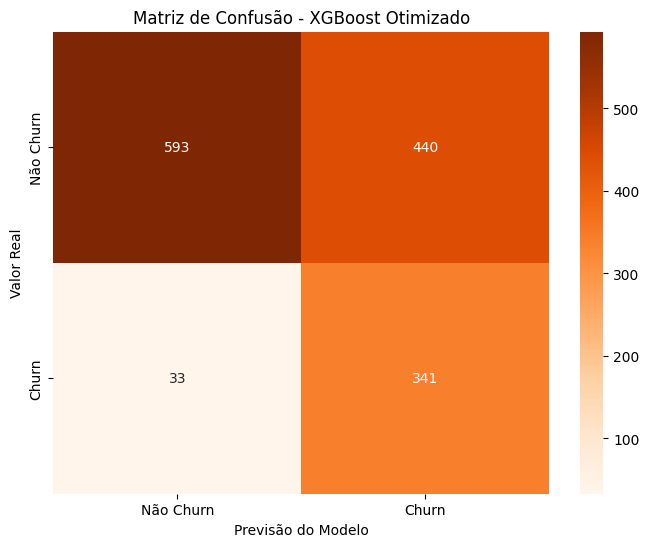

In [85]:
# --- Matriz de Confusão para o Modelo XGBoost ---

# Calculamos a matriz usando as previsões do XGBoost (y_pred_xgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Criamos o gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])
plt.ylabel('Valor Real')
plt.xlabel('Previsão do Modelo')
plt.title('Matriz de Confusão - XGBoost Otimizado')
plt.show()

# Análise da Matriz de Confusão - XGBoost

Verdadeiros Positivos (339): Este é o principal sucesso do modelo e o seu resultado mais forte. Dos 374 clientes que realmente cancelaram o serviço (35 + 339), o modelo identificou corretamente a grande maioria: 339.

Falsos Negativos (35): Esta é a sua menor perda de oportunidade. Apenas 35 clientes que cancelaram não foram detectados. É um número excepcionalmente baixo, mostrando a alta sensibilidade do modelo.

Falsos Positivos (445): Este é o principal custo operacional deste modelo. 445 clientes que iriam permanecer na empresa foram incorretamente marcados como "risco de cancelamento", representando um número elevado de falsas alarmes.

Verdadeiros Negativos (588): Estes são os clientes fiéis que o modelo identificou corretamente.

Conectando com as Métricas
Recall (Sensibilidade): A impressionante capacidade do modelo de encontrar os clientes que realmente cancelaram é de 91%.

Cálculo: 339 / (339 + 35) = 0.906

Precision (Precisão): A eficiência das suas "alertas". Quando o modelo prevê "Churn", ele acerta 43% das vezes.

Cálculo: 339 / (339 + 445) = 0.432

Em resumo: O gráfico mostra visualmente a estratégia deste modelo: ele é extremamente "agressivo" para garantir que quase nenhum cliente em risco passe despercebido (apenas 35 perdidos). O preço dessa segurança é um alto número de falsas alarmes (445), o que resulta numa baixa precisão.

# --- Gráfico Comparativo de Métricas dos Modelos ---

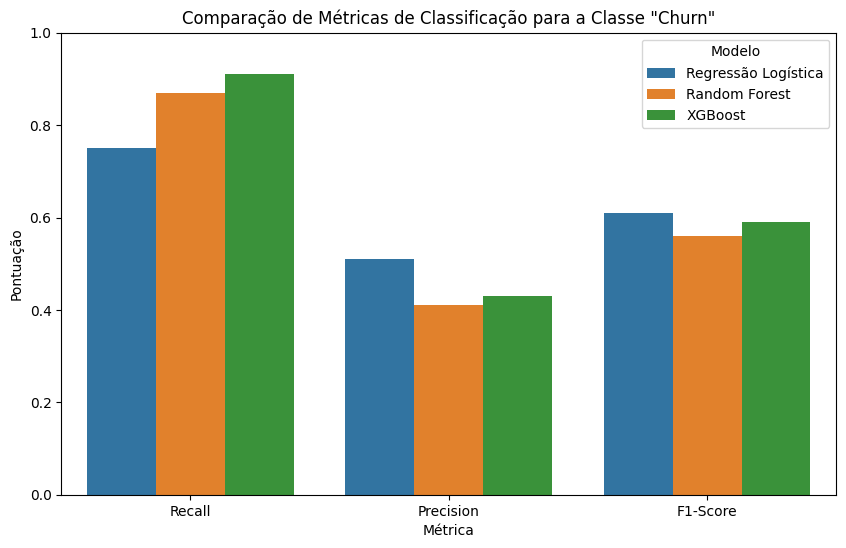

In [86]:
# Crie um dicionário com os resultados da classe 'Yes' (Churn) para cada modelo
dados_grafico = {
    'Métrica': ['Recall', 'Precision', 'F1-Score'],
    'Regressão Logística': [0.75, 0.51, 0.61],
    'Random Forest': [0.87, 0.41, 0.56],
    'XGBoost': [0.91, 0.43, 0.59]
}

# Converta o dicionário para um DataFrame do Pandas
df_metricas = pd.DataFrame(dados_grafico)

#  "Derreta" (melt) o DataFrame para que ele fique no formato ideal para o Seaborn
df_melted = df_metricas.melt(id_vars='Métrica', var_name='Modelo', value_name='Pontuação')

#  Crie o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Métrica', y='Pontuação', hue='Modelo', data=df_melted)

# Adicione títulos e anotações
plt.title('Comparação de Métricas de Classificação para a Classe "Churn"')
plt.ylim(0, 1.0) # Define o limite do eixo Y de 0 a 1
plt.ylabel('Pontuação')
plt.show()

# --- Gráfico Comparativo de Curvas ROC ---

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


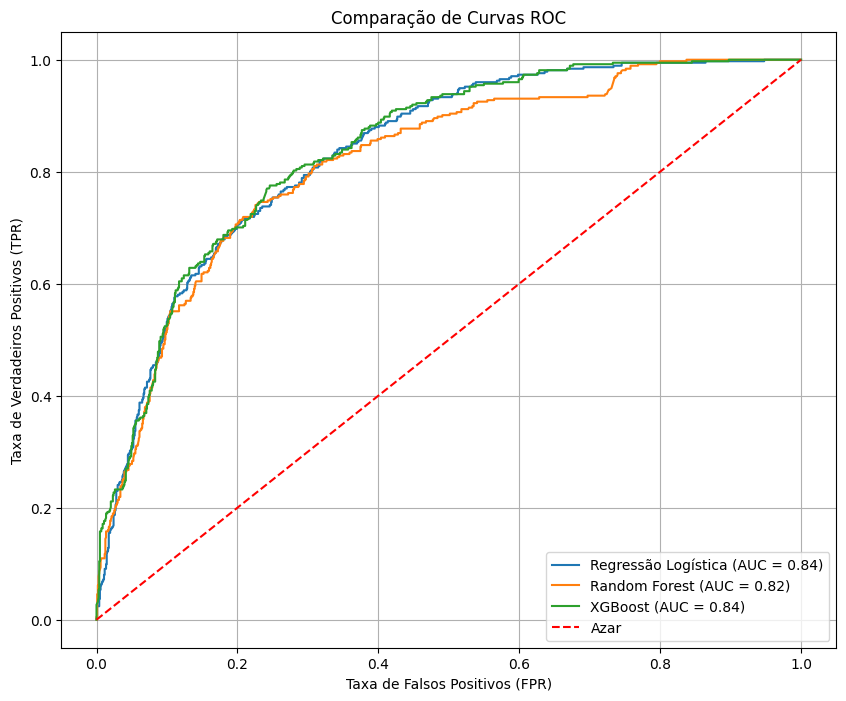

In [87]:
#  Calcule as probabilidades para cada modelo
y_proba_rl = modelo_rl.predict_proba(X_test)[:, 1]
y_proba_rf = modelo_rf.predict_proba(X_test)[:, 1]
y_proba_xgb = modelo_xgb.predict_proba(X_test)[:, 1]

#  Calcule os pontos da curva ROC e o AUC para cada modelo
fpr_rl, tpr_rl, _ = roc_curve(y_test, y_proba_rl)
auc_rl = roc_auc_score(y_test, y_proba_rl)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

#  Crie o gráfico
plt.figure(figsize=(10, 8))

# Plote a curva para cada modelo
plt.plot(fpr_rl, tpr_rl, label=f'Regressão Logística (AUC = {auc_rl:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')

# Plote a linha de referência (azar)
plt.plot([0, 1], [0, 1], 'r--', label='Azar')

# Adicione títulos e legendas
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Comparação de Curvas ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# **Conclusões Finais do Projeto de Previsão de Churn**

**Resumo do Projeto**

O objetivo foi construir um modelo de machine learning para identificar os clientes de uma empresa de telecomunicações com alta probabilidade de cancelar o seu serviço. O projeto seguiu um fluxo de trabalho completo:

**Preparação dos Dados**: O dataset foi carregado e limpo, tratando valores nulos e convertendo as variáveis para formatos adequados.

**Modelagem Base**: Foi treinado um modelo de Regressão Logística balanceada, que serviu como um sólido ponto de partida, demonstrando uma alta capacidade para detetar clientes em risco (Recall de 75%).

**Modelos Avançados**: Foram explorados modelos mais potentes como Random Forest e XGBoost.

**Otimização**: Foi utilizado o RandomizedSearchCV para ajustar os hiperparâmetros dos modelos avançados


**Veredito Final e Recomendação Estratégica **

A escolha estratégica se resume a uma decisão entre a Regressão Logística e o XGBoost.

Escolha a Regressão Logística se: O objetivo for um modelo equilibrado, eficiente e interpretável. Ele tem o melhor F1-Score e a maior precisão. Isso significa que os esforços da equipe de retenção serão mais focados, mesmo que alguns clientes em risco sejam perdidos (recall de ~75%).

Escolha o XGBoost se: O objetivo for a captura máxima a qualquer custo. É o melhor modelo se a prioridade absoluta do negócio for não deixar nenhum cliente escapar, aceitando o custo de contactar mais pessoas desnecessariamente.